In [1]:
import numpy as np
import pylab as plt
%matplotlib inline
import tqdm, json

In [2]:
from frbpa.search import pr3_search, riptide_search, p4j_search
from frbpa.utils import get_phase

In [3]:
with open('r3_data.json', 'r') as f:
    r3_data = json.load(f)

In [4]:
burst_dict = r3_data['bursts']
startmjds_dict = r3_data['obs_startmjds']
duration_dict = r3_data['obs_duration']

In [5]:
r3_data.keys()

dict_keys(['bursts', 'obs_duration', 'obs_startmjds'])

In [6]:
startmjds_dict.keys()

dict_keys(['CHIME', 'DSN_L', 'DSN_S', 'DSN_X', 'Effelsberg', 'GBT300', 'GMRT', 'LOFAR', 'NC', 'SRT_L', 'SRT_P', 'VLA'])

# Let's do periodicity searches using all published bursts of R3

In [7]:
bursts = []
for k in burst_dict.keys():
    bursts += burst_dict[k]
bursts = np.array(bursts)

In [8]:
# bursts = np.sort(bursts - np.min(bursts))
unique_days = np.unique(np.round(bursts))

In [9]:
startmjds = []
for k in startmjds_dict.keys():
    startmjds += startmjds_dict[k]
startmjds = np.array(startmjds)

In [10]:
durations = []
for k in duration_dict.keys():
    durations += duration_dict[k]
durations = np.array(durations)

## Pearson chi-square test ([PR3](https://ui.adsabs.harvard.edu/abs/2020arXiv200110275T/abstract))

### Actually, this method would be less sensitive due to non uniform phase coverage, which is the case here. Look at the Fig 1. (phase plot) in the research note. But, let's still try it...

In [11]:
rch, p = pr3_search(bursts=bursts, obs_mjds=startmjds, 
                    obs_durations=durations)

100%|██████████| 358448/358448 [02:36<00:00, 2283.20it/s]
2020-06-08 14:05:30,846 - pr3_search -root - INFO - Max reduced chi square value is 20.382512542571515 at period of 1.8803803630662275


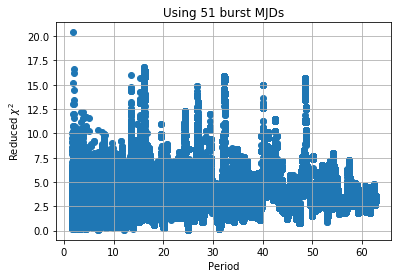

In [12]:
plt.scatter(p, rch)
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.xlabel('Period')
plt.grid()

### Looks like there are many peaks there. The strongest peak is at 1.88 days. There is a weaker peak around 16 days, and then a few more at its harmonics (32, 48 days). Lot of noise! 
#### Let's try just with the activity days

In [13]:
rch_uniq, p = pr3_search(bursts=unique_days, obs_mjds=startmjds, 
                    obs_durations=durations)

100%|██████████| 358807/358807 [02:37<00:00, 2278.97it/s]
2020-06-08 14:08:11,696 - pr3_search -root - INFO - Max reduced chi square value is 119.07057886950665 at period of 1.9932103142087925


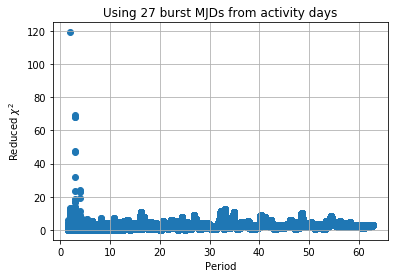

In [14]:
plt.scatter(p, rch_uniq)
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.xlabel('Period')
plt.grid()

### The peak at 16 day period got weaker, and the one at the alias of sidereal day got very strong. Let's zoom in around 16 day

In [15]:
mask = (p > 10) & (p < 40)

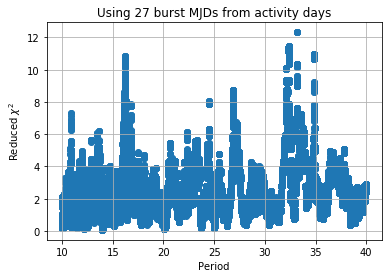

In [16]:
plt.scatter(p[mask], rch_uniq[mask])
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.xlabel('Period')
plt.grid()

#### So there is a peak around 16 day, although there is a lot of noise as well.  

# Searching for period with narrowest folded profile (Rajwade et al 2020)
### Rajwade et al (2020) actually call it searching for the largest continuous fraction in the folded profile without burst signal

In [17]:
bursts = np.sort(bursts - np.min(bursts))
unique_days = np.unique(np.round(bursts))

In [18]:
cont_frac, p = riptide_search(bursts, pmin=1, pmax=50)

2020-06-08 14:08:16,508 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods from 2.0003872966692486 days for search.
100%|██████████| 3542/3542 [00:02<00:00, 1347.43it/s]
2020-06-08 14:08:19,139 - riptide_search -root - INFO - Max continuous fraction without data is 0.725 at a period of 16.267716535433074 days


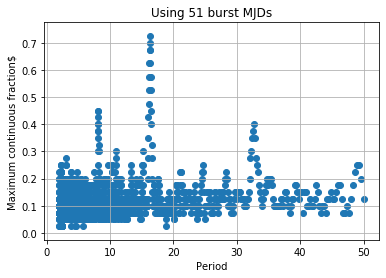

In [19]:
plt.scatter(p, cont_frac)
plt.ylabel(r'Maximum continuous fraction$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.xlabel('Period')
plt.grid()

#### This was quick. :) <br>  As has been noted in the log and can be seen in the plot, strongest peak occurs at 16.26 day period, which is consistent with PR3. <br> Let's just use the unique days now


In [20]:
cont_frac_uniq, p = riptide_search(unique_days, pmin=1, pmax=50)

2020-06-08 14:08:19,327 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods from 2.000088450567189 days for search.
100%|██████████| 3545/3545 [00:02<00:00, 1351.71it/s]
2020-06-08 14:08:21,952 - riptide_search -root - INFO - Max continuous fraction without data is 0.725 at a period of 16.275303643724698 days


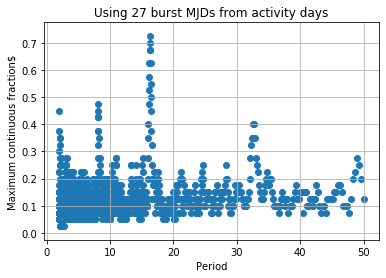

In [21]:
plt.scatter(p, cont_frac_uniq)
plt.ylabel(r'Maximum continuous fraction$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.xlabel('Period')
plt.grid()

#### Again we get a peak at 16.27 day, consistent with PR3. All good. 

# Using P4J
### using QMI based on Euclidean distance for periodogram. See https://github.com/phuijse/P4J

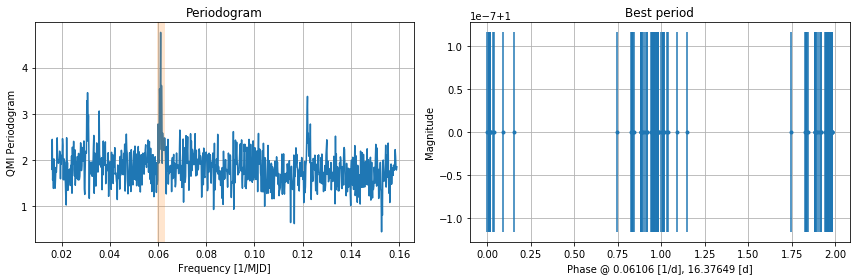

In [22]:
periodogram, p = p4j_search(bursts, pmin=2*np.pi, pmax=np.pi*20, plot=True, save=False, mjd_err=0.01)

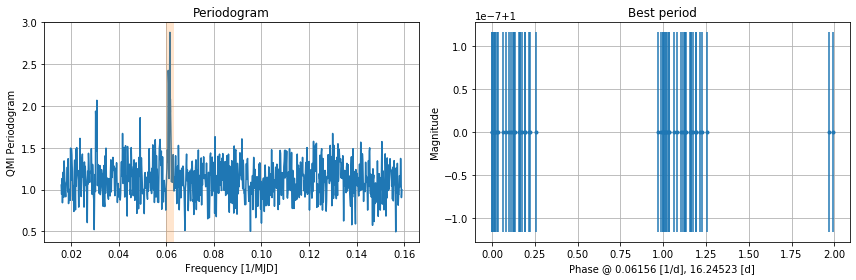

In [23]:
periodogram_unique, p = p4j_search(unique_days, pmin=2*np.pi, pmax=np.pi*20, plot=True, save=False, mjd_err=0.01)

#### P4J recovers the period reported by PR3

#### By using all the available bursts from R3, we are able to recover the period reported by PR3. This again improves the confidence in this period. 